## Importing Necessary Libraries and Making Initial Configurations
---

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

import math

## Loading Audio Files
---

### Filename identifiers

 - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

 - Vocal channel (01 = speech, 02 = song).
 
 - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
 
 - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
 
 - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
 
 - Repetition (01 = 1st repetition, 02 = 2nd repetition).
 
 - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

### RAVDESS Sampling Function

 - allows for customized querying of the RAVDESS dataset based on desired feature types


In [27]:
modality = (1,2,3)
m = "".join(str(s) for s in modality)
g = "-".join("ehhehehehehehe")
g

'e-h-h-e-h-e-h-e-h-e-h-e-h-e'

In [3]:
# takes path of directory containing all actor subdirectories
# tuples are used to specify the desired types for each feature
#   default is set to include everything
def get_RAVDESS_sample(path, modality: tuple = (1,2,3),
                             voice_channel: tuple = (1,2),
                             emotion: tuple = tuple(range(1,9)),
                             intensity: tuple = (1,2),
                             statement: tuple = (1,2),
                             randomize_rep: bool = False,
                             repetition: tuple = (1,2), # input will be ignored if randomized_rep = True
                             actor: tuple = tuple(range(1,25))):
    
    m = "".join(str(s) for s in modality)
    vc = "".join(str(s) for s in voice_channel)
    e = "".join(str(s) for s in emotion)
    i = "".join(str(s) for s in intensity)
    s = "".join(str(s) for s in statement)
    a = "".join(str(s) for s in actor)
    
    dirs = []
    for d in glob(path+"/Actor_*"):
        if (int(d[-2]+d[-1]) in actor):
            dirs.append(d)

    files = []
    for d in dirs:
        d = d+"/"
        
        for f in glob(d+"*"):    
            f = f.replace(d, "")
                      
            if (m in modality) and (vc in voice_channel) and (e in emotion) and (i in intensity) and (s in statement) and (r in repetition):
                f = d + "".join(f)
                files.append(f)
    
    return files

    

### Sampling Method

The goal was to extract a sample from the dataset that was significantly smaller in size and computationally inexpensive, while preserving the original dataset's variability.

All emotional variations and intensities for a single repetition of a given statement were extracted. For statement 1, data came from the first half of the dataset (Actors 1-12), and for statement 2 data came from the second half (Actors 13-24). This ensured that variability across emotion type, emotional intensity and actor gender was retained. Furthermore, the inclusion of only one repitition for all statements and the consideration of only a single statement type for each actor resulted in a 4-fold reduction in sample size.

In [15]:
# storing list of all sound file paths
audio_files = get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(1,), repitition=(1,), actor=list(range(1,13)))
audio_files.extend(get_RAVDESS_sample("./sound_files", (3,), (1,), statement=(2,), repitition=(1,), actor=list(range(13,25))))
print(len(audio_files))

360


In [5]:
# loading audio file using librosa
digital_signal, sample_rate = librosa.load(audio_files[15], sr=None, mono=True)
print(f"number of samples: {len(digital_signal)}")
print(f"original sample rate: {sample_rate}/s")
print(f"audio duration: {len(digital_signal)/sample_rate}")

number of samples: 193793
original sample rate: 48000/s
audio duration: 4.037354166666667


## Analyzing and Preparing Audio Files
---

In [6]:
def plot_signal(signal, sample_rate, plot_title = "Audio Signal"):
    df = pd.DataFrame({
        'signals' : signal,
        'seconds' : [i/sample_rate for i in range(0, len(signal))]
    })
    df.plot(y="signals", x="seconds", figsize=(15,5), lw=0.1, title=plot_title, xlabel="seconds", ylabel="amplitude")

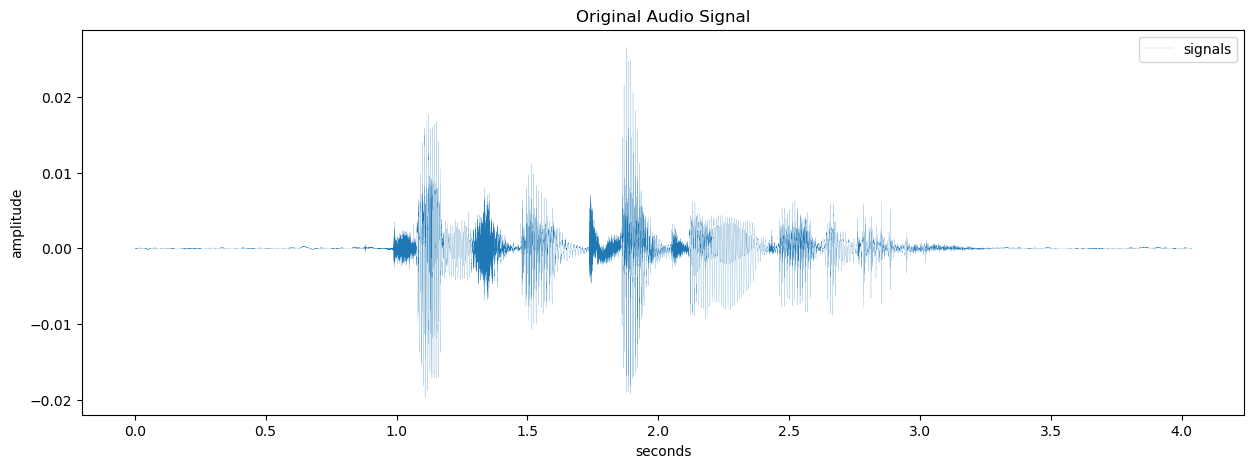

In [7]:
# plotting digital signal
plot_signal(digital_signal, sample_rate, "Original Audio Signal")
ipd.Audio(digital_signal, rate=sample_rate)

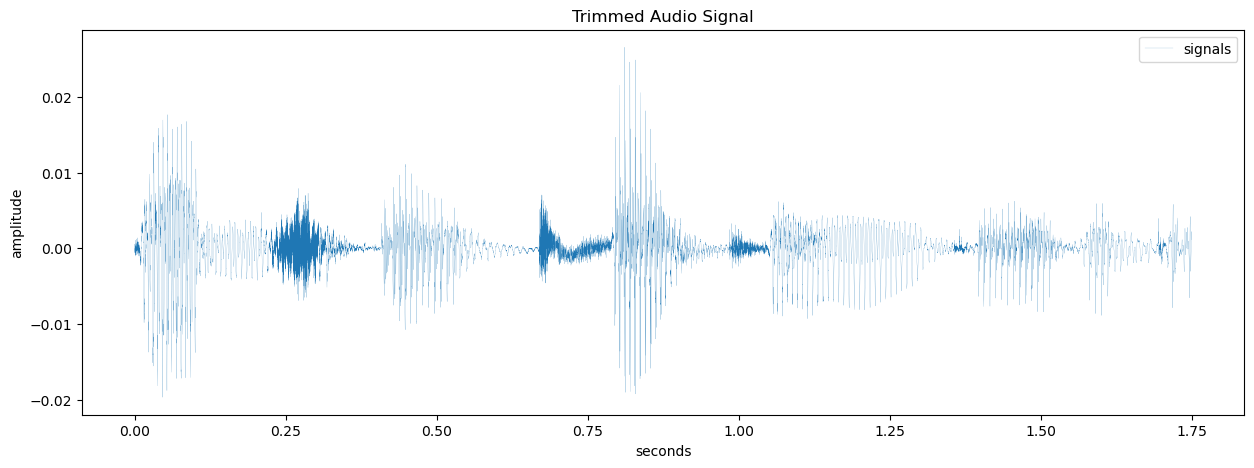

In [8]:
# trimmed signal
db = 20 * (math.log10(max(digital_signal)) - math.log10(0.005))
trimed_signal, _ = librosa.effects.trim(digital_signal, top_db=db)
plot_signal(trimed_signal, sample_rate, "Trimmed Audio Signal")
ipd.Audio(trimed_signal, rate=sample_rate)

## Adding Noise
---

In [9]:
# noise generation functions

def generate_white_noise_gaussian(length, std_dev=0.1):
    return np.random.normal(0, std_dev, length)

def generate_white_noise_uniform(length):
    return np.random.uniform(-1,1,length)


# mixing function

def add_noise(noise_type, signal, snr=1):
    
    signal_len = len(signal)
    signal_power = np.sum(signal**2)/signal_len
    signal_std_dev = np.std(signal)
    
    if noise_type == 'n':
        noise = generate_white_noise_gaussian(signal_len, signal_std_dev)
    else:
        noise = generate_white_noise_uniform(signal_len)
    
    noise_power = np.sum(noise**2)/signal_len
    scale_factor = math.sqrt( (signal_power/noise_power)*(10**(-snr/10)) )
    
    noise *= scale_factor
    noisy_audio = noise + signal
    
    return noisy_audio
    

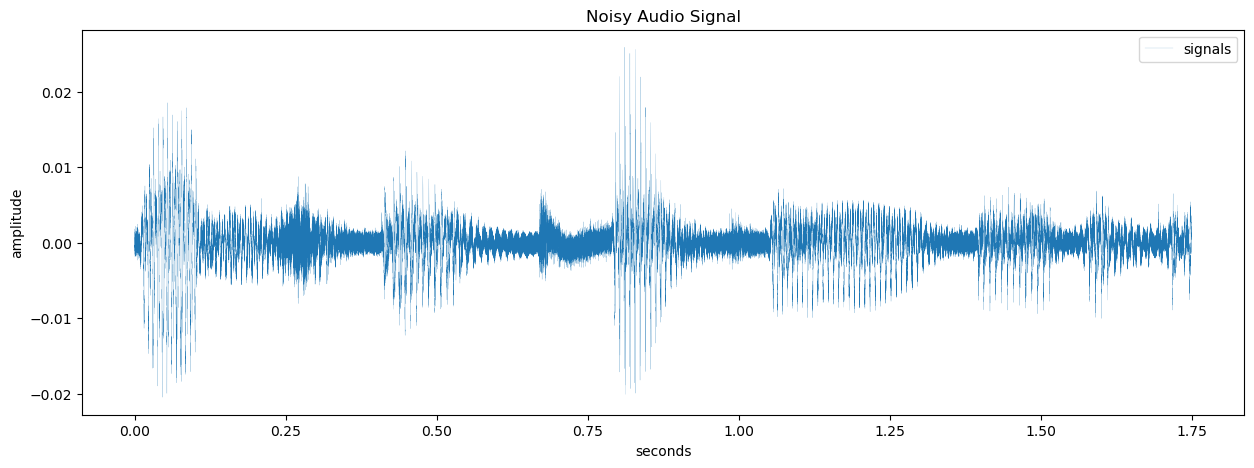

In [10]:
# requesting desired signal to noise ratio
snr = input("Please enter the required signal to noise ratio")
snr = int(snr)

# generating noisy audio
choice = input("Enter 'n' for gaussian white noise or 'u' for uniform white noise")

noisy_audio = add_noise(choice, trimed_signal, snr=snr)    
plot_signal(noisy_audio, sample_rate, "Noisy Audio Signal")
ipd.Audio(noisy_audio, rate=sample_rate)